In [1]:
from netCDF4 import Dataset
#import math
#import seaborn as sns
from scipy import stats
#from scipy.stats.kde import gaussian_kde
from numpy import linspace
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import matplotlib.pyplot as plt
#import matplotlib as mpl
#mpl.use("Qt4Agg")
#mpl.use('Qt4Agg')
#mpl.interactive(False)
#from matplotlib.colors import BoundaryNorm
#from matplotlib.ticker import MaxNLocator
from os import path
#from mayavi import mlab
#import matplotlib.mlab as mlab
#import matplotlib.animation as animation
#mlab.init_notebook('png', 400, 300)
#database & file io
#from io import StringIO
#import matplotlib.animation as animation
#import animatplot as amp

In [2]:
#import flow data 
dir='/glade/u/home/sisichen/Github/aerosol/git_aerosol/'
#dir='/glade/u/home/sisichen/IUGG_UAE/DNS_model/condensation_only/noseed_gravity/'

case='pichamber_for'
dynancfile=dir+'out.ncf' #dir+case+'.ncf'
#fh = Dataset(dynancfile,mode='r')
#ZX=fh.variables['ZX'][:]
#ZY=fh.variables['ZY'][:]
#ZZ=fh.variables['ZZ'][:]
#QV=fh.variables['QV'][:]
#TH=fh.variables['TH'][:]
#U=fh.variables['U'][:]
#fh.close()
#load flow field and assign coordinates
ds = xr.open_dataset(dynancfile)
ds_coords=ds.assign_coords(T=ds.TIMES,X=np.linspace(0,0.165,128),Y=np.linspace(0,0.165,128),Z=np.linspace(0,0.165,128))


In [3]:
#import droplet data
dir='/glade/u/home/sisichen/Github/aerosol/git_aerosol/'
#meanfile
#df = pd.read_csv('droplet_new.track',sep='\s+',header=None,names=['time','id','x','y','z','r','s'])
#calculate supersaturation fields
meanfile=dir+case+'.nc'
Time=150
case_time=str(Time)
ds_mean=pd.read_csv(meanfile,sep='\s+',index_col=False, header = None, names=\
        ['time','Sp','pp','temp0','thetapp','qvpp','lwc','qvs','rmth','rmqv','s'])
ds_mean_select=ds_mean.iloc[(ds_mean['time']-Time).abs().argsort()[:1]]
d_index=ds_mean_select.index[0]
temp0=ds_mean_select.temp0[d_index]
pp=ds_mean_select.pp[d_index]
qv=ds_mean_select.qvpp[d_index]
Sp=ds_mean_select.Sp[d_index]
eps=287/467
esat = 2.53e11*np.exp(-5.42e3/(temp0+ds_coords.TH))
qvs = eps*esat/(pp-esat)
Supersat=(qv+ds_coords.QV)/(qvs)-1.0

FileNotFoundError: [Errno 2] File b'/glade/u/home/sisichen/Github/aerosol/git_aerosol/pichamber_for.nc' does not exist: b'/glade/u/home/sisichen/Github/aerosol/git_aerosol/pichamber_for.nc'

case sigma skew


<Figure size 432x288 with 0 Axes>

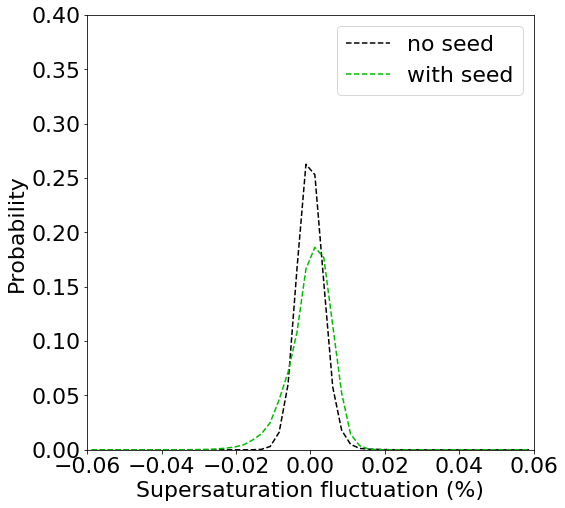

In [14]:
##plot PDF of supersat
r_seed=[0,10]#[0,1,5,10]
N_seed=[0,10]#['0_gravity',0,1,5,10]
ncolor = 3#12#ncolor=len(N_seed)*len(r_seed)
color_new=plt.cm.nipy_spectral(np.linspace(0,1,ncolor))
Time=300
case_time=str(Time)
plt.clf()
fig,ax=plt.subplots(figsize=(8, 8))
plt.xlabel('Supersaturation fluctuation (%)')
plt.ylabel('Probability')
n=0
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
num_bins=50
ranges=(-6e-2,6e-2 )
eps=287/467
print('case','sigma','skew')
dir='/glade/u/home/sisichen/IUGG_UAE/DNS_model/condensation_collision/out_T'+case_time+'/'
for (irseed,inseed) in itertools.product(r_seed,N_seed):
    case='r'+str(irseed)+'n'+str(inseed)
    meanfile=dir+case+'.nc'
    dynancfile=dir+case+'.ncf'
    
    if path.exists(dynancfile):
        ds = xr.open_dataset(dynancfile)
        ds_coords=ds.assign_coords(T=ds.TIMES,X=np.linspace(0,0.165,128),Y=np.linspace(0,0.165,128),Z=np.linspace(0,0.165,128))
        ds_mean=pd.read_csv(meanfile,sep='\s+',index_col=False, header = None, names=\
            ['time','Sp','pp','temp0','thetapp','qvpp','lwc','qvs','rmth','rmqv','s'])
        ds_mean_select=ds_mean.iloc[(ds_mean['time']-Time).abs().argsort()[:1]]
        d_index=ds_mean_select.index[0]
        temp0=ds_mean_select.temp0[d_index]
        pp=ds_mean_select.pp[d_index]
        qv=ds_mean_select.qvpp[d_index]
        Sp=ds_mean_select.Sp[d_index]
        esat = 2.53e11*np.exp(-5.42e3/(temp0+ds_coords.TH))
        qvs = eps*esat/(pp-esat)
        Supersat=((qv+ds_coords.QV)/(qvs)-1.0)*1e2
        B=np.ravel(Supersat)
        # the histogram of the data
        mu=B.mean()
        sigma=np.std(B)
        skew=stats.skew(B)
        A=(B-mu)
        histogram, bins = np.histogram(A, bins=num_bins, range=ranges,density=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        bin_width=(bins[1:]-bins[:-1])
        C=histogram/sum(histogram)
        if irseed==0 and str(inseed)=='0_gravity':
            figlabel='noseed_gravity'
        elif irseed == 0 & inseed == 0:
            figlabel='no seed'
        else:
            figlabel='with seed'#'r='+str(irseed)+'$\mu m$, n='+str(inseed)+'$cm^{-3}$'
        ax.plot(bin_centers,C,label=figlabel,color=color_new[n],linestyle='--')
        n=n+1
        #print(case,sigma,skew)
ax.legend(bbox_to_anchor=(1, 1))
#ax.set_yscale('log')
plt.rc('font', size=BIGGER_SIZE) 
plt.xlim(ranges)
plt.ylim(0,.35)
figname='Ss_PDF_T'+case_time+'.png'
#fig.savefig(figname)
plt.rcParams.update({'font.size': 22})

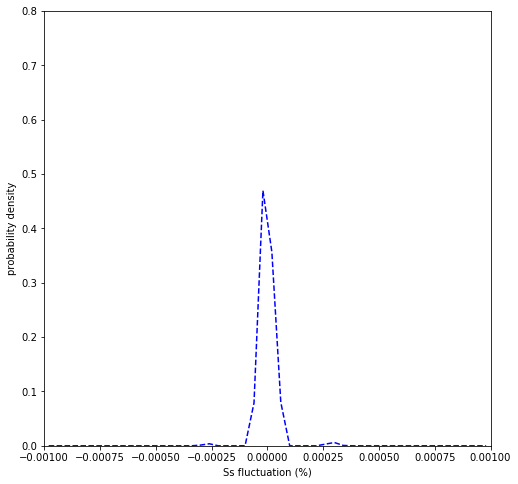

In [114]:
#for single PDF
Time=8
x_location=0.04
case_time=str(Time)
fig,ax=plt.subplots(figsize=(8, 8))
eps=287/467
ranges=(-1e-3,1e-3 )
meanfile='/glade/u/home/sisichen/work_dir/scaleup_experiments/sensitivity_Ss_N/n130_ccn/Test_N130.nc'
dynancfile='/glade/u/home/sisichen/work_dir/scaleup_experiments/sensitivity_Ss_N/n130_ccn/out2.ncf'
num_bins=50
#fig,ax=plt.subplots(figsize=(8, 8))
plt.xlabel('Ss fluctuation (%)')
plt.ylabel('probability density')
if path.exists(dynancfile):
        ds = xr.open_dataset(dynancfile)
        ds_coords=ds.assign_coords(T=ds.TIMES,X=np.linspace(0,0.083,64),Y=np.linspace(0,0.083,64),Z=np.linspace(0,0.083,64))
        ds_slices=ds_coords.sel(T=Time,method='nearest')
        
        ds_mean=pd.read_csv(meanfile,sep='\s+',index_col=False, header = None, names=\
            ['time','Sp','pp','temp0','thetapp','qvpp','lwc','qvs','rmth','rmqv','s','rm'])
        ds_mean_select=ds_mean.iloc[(ds_mean['time']-Time).abs().argsort()[:1]]
        d_index=ds_mean_select.index[0]
        temp0=ds_mean_select.temp0[d_index]
        pp=ds_mean_select.pp[d_index]
        qv=ds_mean_select.qvpp[d_index]
        Sp=ds_mean_select.Sp[d_index]
        esat = 2.53e11*np.exp(-5.42e3/(temp0+ds_slices.TH))
        qvs = eps*esat/(pp-esat)
        Supersat=(qv+ds_slices.QV)/(qvs)-1.0
        B=np.ravel(Supersat)*1e2
        # the histogram of the data
        mu=B.mean()
        sigma=np.std(B)
        skew=stats.skew(B)
        A=(B-mu)
        histogram, bins = np.histogram(A, bins=num_bins, range=ranges,density=True)
        bin_centers = 0.5*(bins[1:] + bins[:-1])
        bin_width=(bins[1:]-bins[:-1])
        C=histogram/sum(histogram)
        ax.plot(bin_centers,C,color='blue',linestyle='--')
        plt.xlim(ranges)
        plt.ylim(0,.8)
        #print(case,sigma,skew)

r10n5
r10n10


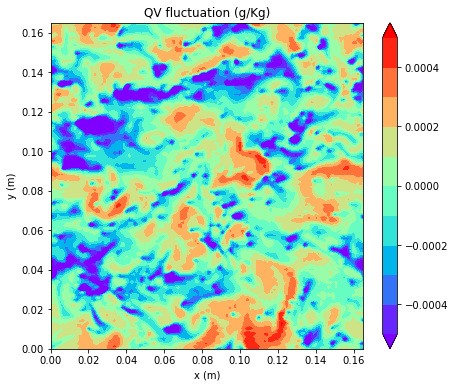

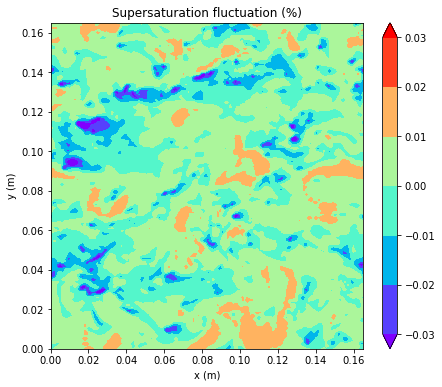

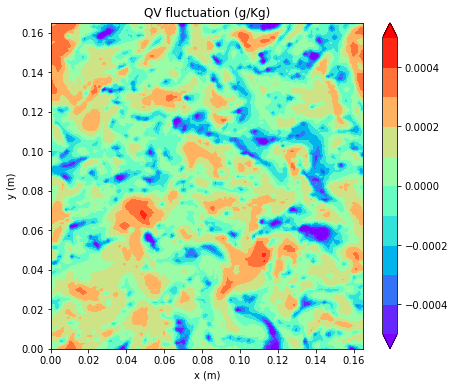

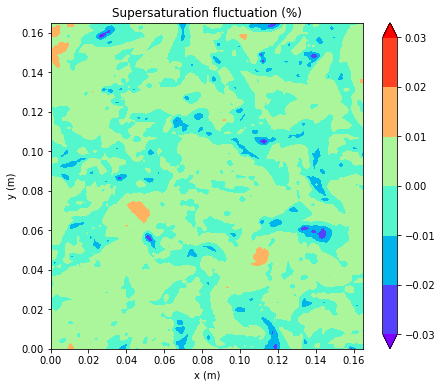

In [4]:
%matplotlib inline
#plot disstribution of QV & Supersat
r_seed=[10]#[0,1,5,10]
N_seed=['0_gravity',0,1,5,10]
Time=330
x_location=0.08 #slides of X near 0.08m
case_time=str(Time)
#2D color meshgrid
dx, dy = 16.5e-2/127, 16.5e-2/127
y,z = np.mgrid[slice(0,16.5e-2+dx,dx),slice(0,16.5e-2+dy,dy)]
eps=287/467
dir='/glade/u/home/sisichen/IUGG_UAE/DNS_model/condensation_collision/out_T'+case_time+'/'
for (irseed,inseed) in itertools.product(r_seed,N_seed):
    case='r'+str(irseed)+'n'+str(inseed)
    meanfile=dir+case+'.nc'
    dynancfile=dir+case+'.ncf'
    if path.exists(dynancfile) and path.exists(meanfile):
        print(case)
        #load flow field and assign coordinates
        ds = xr.open_dataset(dynancfile)
        ds_coords=ds.assign_coords(T=ds.TIMES,X=np.linspace(0,0.165,128),Y=np.linspace(0,0.165,128),Z=np.linspace(0,0.165,128))
        #import parcel mean data
        #calculate supersaturation fields
        ds_mean=pd.read_csv(meanfile,sep='\s+',index_col=False, header = None, names=\
            ['time','Sp','pp','temp0','thetapp','qvpp','lwc','qvs','rmth','rmqv','s'])
        ds_mean_select=ds_mean.iloc[(ds_mean['time']-Time).abs().argsort()[:1]]
        d_index=ds_mean_select.index[0]
        temp0=ds_mean_select.temp0[d_index]
        pp=ds_mean_select.pp[d_index]
        qv=ds_mean_select.qvpp[d_index]
        Sp=ds_mean_select.Sp[d_index]
        esat = 2.53e11*np.exp(-5.42e3/(temp0+ds_coords.TH))
        qvs = eps*esat/(pp-esat)
        Supersat=(qv+ds_coords.QV)/(qvs)-1.0
  ##QV
        ds_slices=ds_coords.sel(T=Time,X=x_location,method='nearest') #select one slice at one timeframe
        #vort_slices=ds_slices.ZX**2+ds_slices.ZY**2+ds_slices.ZZ
        field_slice=ds_slices.QV
        levels=np.linspace(-5e-4,5e-4,11)
        fig1, ax1 = plt.subplots(figsize=(7, 6))
        cs1=ax1.contourf(z,y,field_slice*1e3, cmap='rainbow',levels=levels, extend='both')
        fig1.colorbar(cs1, boundaries=levels)
        plt.title('QV fluctuation (g/Kg)')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        figname_qv=case+'QV_T'+case_time+'.png'
        fig1.savefig(figname_qv)
##supersat
        ds_slices=Supersat.sel(T=Time,X=x_location,method='nearest') #select one slice at one timeframe
        field_slice=ds_slices
        levels=np.linspace(-0.03,0.03,7)
        fig, ax = plt.subplots(figsize=(7, 6))
        cs1=ax.contourf(z,y,field_slice*1e2-field_slice.mean()*1e2, cmap='rainbow',levels=levels, extend='both')
        fig.colorbar(cs1)
        plt.title('Supersaturation fluctuation (%)')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        figname=case+'Ss_T'+case_time+'.png'
        fig.savefig(figname)

In [7]:
figname

'r10n10Ss_T330.png'

Text(0, 0.5, 'y (m)')

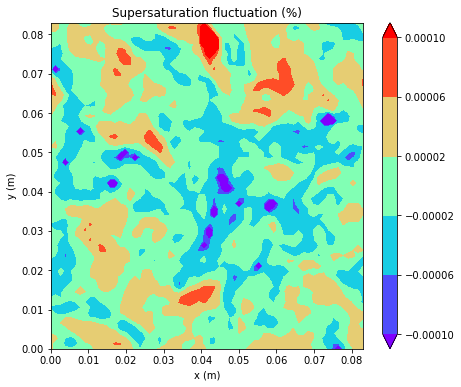

In [85]:
#plot supersat distribution on Scale-up testruns
%matplotlib inline

#meanfile='/glade/u/home/sisichen/work_dir/scaleup_experiments/sensitivity_Ss_N/n130_ccn/Test_N130.nc'
#dynancfile='/glade/u/home/sisichen/work_dir/scaleup_experiments/sensitivity_Ss_N/n130_ccn/out2.ncf'
x_location=0.04 #slides of X near 0.08m
ds_slices=Supersat.sel(T=Time,X=x_location,method='nearest') #select one slice at one timeframe
#vort_slices=ds_slices.ZX**2+ds_slices.ZY**2+ds_slices.ZZ
field_slice=ds_slices
#plot the fields slice
dx, dy = 8.3e-2/63, 8.3e-2/63
y,z = np.mgrid[slice(0,8.3e-2+dx,dx),slice(0,8.3e-2+dy,dy)]
#2D colormesh
levels=np.linspace(-1e-4,1e-4,6)
fig, ax = plt.subplots(figsize=(7, 6))
cs1=ax.contourf(z,y,field_slice*1e2-field_slice.mean()*1e2, cmap='rainbow',levels=levels, extend='both')
cs1=ax.contourf(z,y,field_slice*1e2-field_slice.mean()*1e2, cmap='rainbow',levels=levels, extend='both') #,shading='flat'
fig.colorbar(cs1)
plt.title('Supersaturation fluctuation (%)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
#figname=case+'Ss_T'+case_time+'.png'
#fig.savefig(figname)

In [51]:
Supersat

<xarray.DataArray (Y: 64, Z: 64, X: 64)>
array([[[-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        ...,
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092]],

       [[-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        ...,
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092]],

       ...,

       [[-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        ...,
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092]],

       [[-0.001092, -0.001092, ..., -0.001092, -0.001092],
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
        ...,
        [-0.001092, -0.001092, ..., -0.001092, -0.001092],
   

In [ ]:

#2D contour
fig, ax = plt.subplots(figsize=(7, 6))
cs2=ax.contour(ds_slices.Y, ds_slices.Z, field_slice*1e7,levels=levels)
plt.clabel(cs2, inline=1,fmt='%r',fontsize=10)
plt.xlabel('y(m)')
plt.ylabel('z(m)')
plt.ylim([0 ,0.16])
plt.xlim([0 ,0.16])
plt.title('QV fluctuation (g/Kg $* 10^4$)')
plt.colorbar(cs2)
fig.savefig('test.png')

In [142]:
#set up 3D grid points
x1=np.linspace(0,8.3,64)
y1=np.linspace(0,8.3,64)
z1=np.linspace(0,8.3,64)
yv,zv,xv = np.meshgrid(y1,z1,x1,indexing='ij')

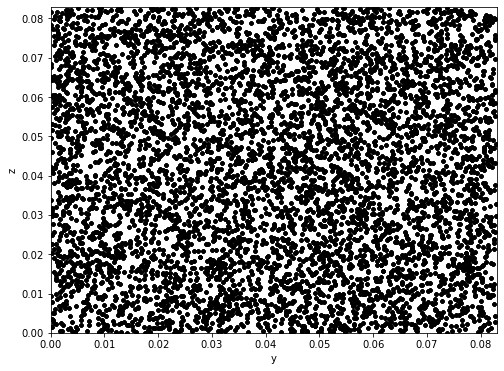

In [26]:
fig,ax1 = plt.subplots(figsize=(8, 6))
ax1.set_xlabel('y')
ax1.set_ylabel('z')
ax1.set_xlim(0,0.083)
ax1.set_ylim(0,0.083)
dx, dy = 8.3e-2/63, 8.3e-2/63
y,z = np.mgrid[slice(0,8.3e-2+dx,dx),slice(0,8.3e-2+dy,dy)]

ds_slice=ds_coords.sel(X=ds_coords.X[31])#select one slice
vort_slice=ds_slice.ZX**2+ds_slice.ZY**2+ds_slice.ZZ**2
field_slice=vort_slice
images=[]
times=ds_coords.TIMES
for i in range(1,15):
    field_slice_tp=field_slice.sel(T=times[i])
    ydrop=df[df['time']==df.time[i]].y
    zdrop=df[df['time']==df.time[i]].z
    #image1,  = ax1.pcolormesh(y,z,field_slice_tp, cmap='rainbow',shading='gouraud',vmin=0, vmax=30000)
    image2,  = ax1.plot(ydrop,zdrop,'.',color='black', alpha=0.5)
    #fig.colorbar(image1,ax=ax)
    images.append([image2])


In [295]:

import animatplot as amp

In [280]:

ds_slice=ds_coords.sel(X=ds_coords.X[31])#select one slice
vort_slice=ds_slice.ZX**2+ds_slice.ZY**2+ds_slice.ZZ**2
field_slice=vort_slice
ds_coords.TIMES[0]
times=ds_coords.TIMES
field_slice_tp=field_slice.sel(T=times[0])
field_slice_tp

<xarray.DataArray (Y: 64, Z: 64)>
array([[ 7882.176  , 11307.041  ,  7872.3394 , ...,   379.4458 ,   217.79495,
         3604.101  ],
       [ 7227.4414 , 11911.521  ,  9704.545  , ...,  1037.0466 ,   396.1455 ,
         2352.9207 ],
       [ 7742.872  , 11552.936  ,  9695.293  , ...,  4803.6357 ,  4418.9897 ,
         4256.306  ],
       ...,
       [ 5307.1665 ,  3088.0083 ,  1761.9363 , ...,  3450.592  ,   358.9452 ,
         5065.272  ],
       [ 6236.4624 ,  5810.915  ,  2893.4375 , ...,  3612.1492 ,   358.4559 ,
         4494.154  ],
       [ 7432.2056 ,  8093.865  ,  4489.1484 , ...,   670.7163 ,   410.2006 ,
         4954.3916 ]], dtype=float32)
Coordinates:
    T        float32 0.31450933
    X        float64 0.04084
  * Y        (Y) float64 0.0 0.001317 0.002635 ... 0.08037 0.08168 0.083
  * Z        (Z) float64 0.0 0.001317 0.002635 ... 0.08037 0.08168 0.083

ValueError: too many values to unpack (expected 2)

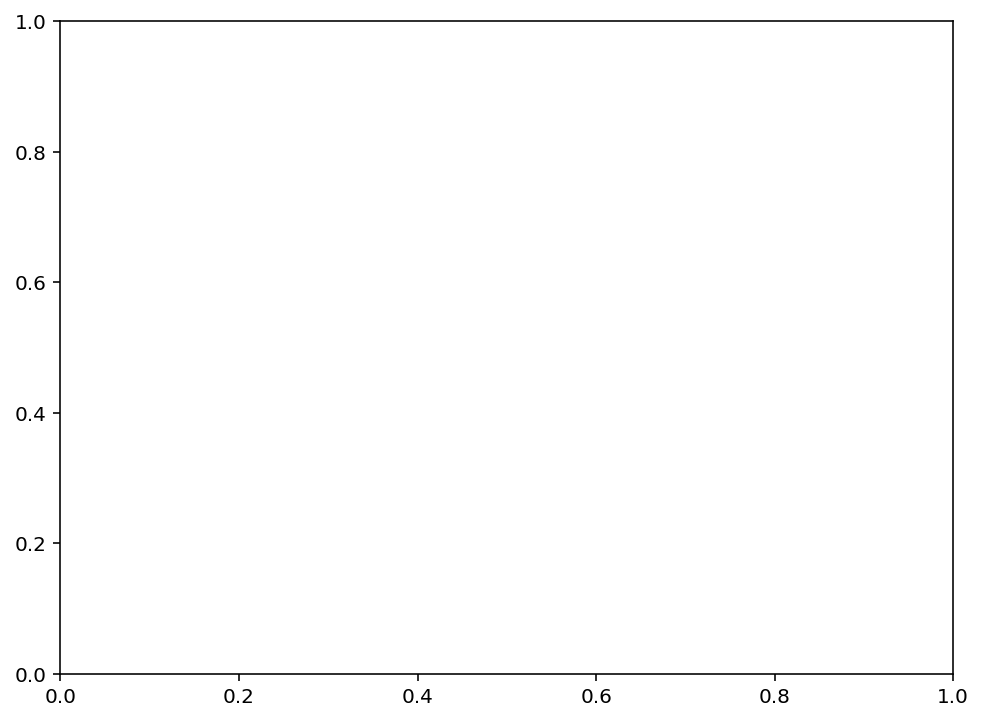

In [250]:
#get the slice info and plot
ds_slices=ds_coords.sel(T=ds_coords.TIMES[0],X=ds_coords.X[31]) #select one slice at one timeframe
vort_slices=ds_slices.ZX**2+ds_slices.ZY**2+ds_slices.ZZ
droplets_slice=df[df['time']==df.time[0]].copy()
droplets_slice=droplets_slice[abs(droplets_slice['x']-x_location)<0.04].copy()
fig,ax = plt.subplots(figsize=(8, 6))
im1=ax.pcolormesh(y,z,field_slice, cmap='rainbow',shading='gouraud',vmin=0, vmax=30000)
fig.colorbar(im1,ax=ax)
im2=ax.scatter(droplets_slice.y, droplets_slice.z, s=1, color='black', alpha=0.5)
plt.ylim(bottom=0,top=0.083)
plt.xlim(left=0,right=0.083)

/bin/sh: sshpass: command not found
